# Bitcoin Whale Intelligence Analysis

**Objective**: Identify and analyze Bitcoin whales by clustering addresses into entities using the Common Input Ownership Heuristic.

| Section | Description |
|---------|-------------|
| 1. Setup | Configuration and imports |
| 2. Data Loading | Load blockchain data from bitcoin-etl exports |
| 3. Data Exploration | Quick overview of transaction patterns |
| 4. Entity Clustering | Group addresses using graph analysis |
| 5. Results & Insights | Whale identification and visualization |
| 6. Executive Summary | Key findings and business implications |

---
## 1. Setup

In [1]:
import sys
from pathlib import Path
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import (
    col, count, sum as spark_sum, avg, desc, when, round as spark_round,
    explode, collect_set, size as spark_size
)
from pyspark.sql.types import ArrayType, StructType, StructField, StringType
from pyspark.sql.functions import udf

project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

from src.etl import (
    create_spark_session, load_transactions, load_blocks,
    explode_outputs, explode_inputs, compute_utxo_set, enrich_clustering_inputs
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 100,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 11,
    'font.size': 10
})
COLORS = {'primary': '#2E86AB', 'secondary': '#A23B72', 'accent': '#F18F01', 'dark': '#1B1B1E'}

In [2]:
BLOCKCHAIN_DATA_PATH = "/Users/roman/spark_project/blockchain_exports"
OUTPUT_PATH = str(project_root / "data")
DRIVER_MEMORY = "16g"

Path(OUTPUT_PATH).mkdir(exist_ok=True)
print(f"Data source: {BLOCKCHAIN_DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")

Data source: /Users/roman/spark_project/blockchain_exports
Output path: /Users/roman/spark_project/bitcoin-whale-intelligence/data


In [3]:
%%time
spark = create_spark_session(app_name="Bitcoin Whale Analysis", driver_memory=DRIVER_MEMORY, enable_graphframes=True)
spark.sparkContext.setCheckpointDir(str(Path(OUTPUT_PATH) / "checkpoints"))
print(f"Spark {spark.version} initialized | UI: {spark.sparkContext.uiWebUrl}")

Spark 3.5.7 initialized | UI: http://localhost:4040
CPU times: user 7.29 ms, sys: 11.2 ms, total: 18.4 ms
Wall time: 1.79 s


---
## 2. Data Loading

Loading Bitcoin blockchain data exported via [bitcoin-etl](https://github.com/blockchain-etl/bitcoin-etl). The data contains nested JSON structures for transaction inputs and outputs.

**Key Concept - UTXOs:** Unspent Transaction Outputs are Bitcoin's way of tracking balances. Unlike bank accounts, Bitcoin has no "balance" field - your wealth is the sum of all unspent outputs you control.

In [4]:
%%time
tx_df = load_transactions(spark, BLOCKCHAIN_DATA_PATH).cache()
blocks_df = load_blocks(spark, BLOCKCHAIN_DATA_PATH).cache()

TX_COUNT = tx_df.count()
BLOCK_COUNT = blocks_df.count()

print(f"Loaded {TX_COUNT:,} transactions from {BLOCK_COUNT:,} blocks")

Loaded 382,402 transactions from 27,644 blocks
CPU times: user 3.11 ms, sys: 2.67 ms, total: 5.79 ms
Wall time: 6.84 s


In [5]:
%%time
outputs_df = explode_outputs(tx_df).cache()
inputs_df = explode_inputs(tx_df).cache()
utxo_df = compute_utxo_set(outputs_df, inputs_df).cache()

OUTPUT_COUNT = outputs_df.count()
UTXO_COUNT = utxo_df.count()
SPENT_COUNT = OUTPUT_COUNT - UTXO_COUNT

print(f"Outputs: {OUTPUT_COUNT:,} | Spent: {SPENT_COUNT:,} ({SPENT_COUNT/OUTPUT_COUNT*100:.1f}%) | UTXOs: {UTXO_COUNT:,} ({UTXO_COUNT/OUTPUT_COUNT*100:.1f}%)")

Outputs: 769,081 | Spent: 592,040 (77.0%) | UTXOs: 177,041 (23.0%)
CPU times: user 4.57 ms, sys: 3.51 ms, total: 8.07 ms
Wall time: 3.34 s


---
## 3. Data Exploration

Analyzing transaction patterns to understand the clustering potential. Multi-input transactions (>=2 inputs) reveal address ownership through the **Common Input Ownership Heuristic**: addresses used together as inputs are controlled by the same entity.

In [6]:
input_dist = tx_df.filter(col("is_coinbase") == False) \
    .groupBy("input_count").agg(count("*").alias("tx_count")) \
    .orderBy("input_count").toPandas()

total_non_coinbase = input_dist['tx_count'].sum()
single_input = input_dist[input_dist['input_count'] == 1]['tx_count'].sum()
multi_input = input_dist[input_dist['input_count'] > 1]['tx_count'].sum()

print(f"Transaction Input Analysis")
print(f"{'='*50}")
print(f"Total (non-coinbase): {total_non_coinbase:,}")
print(f"Single-input:         {single_input:,} ({single_input/total_non_coinbase*100:.1f}%)")
print(f"Multi-input:          {multi_input:,} ({multi_input/total_non_coinbase*100:.1f}%) <- usable for clustering")

Transaction Input Analysis
Total (non-coinbase): 354,758
Single-input:         287,512 (81.0%)
Multi-input:          67,246 (19.0%) <- usable for clustering


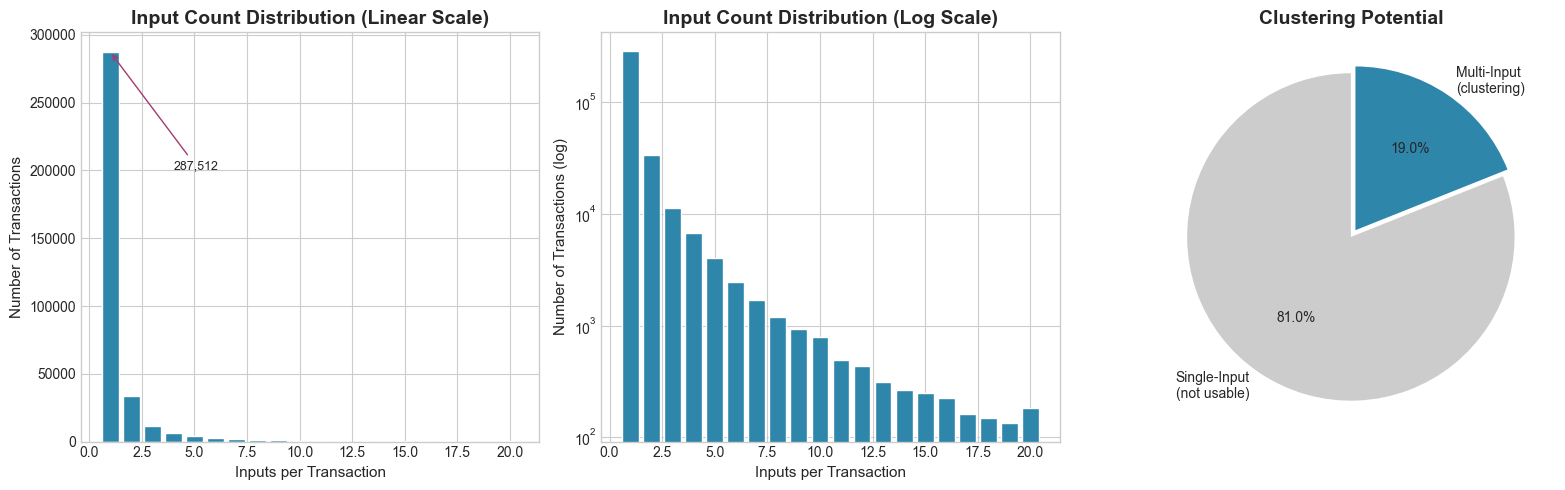

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

plot_data = input_dist[input_dist['input_count'] <= 20]

axes[0].bar(plot_data['input_count'], plot_data['tx_count'], color=COLORS['primary'], edgecolor='white')
axes[0].set_xlabel('Inputs per Transaction')
axes[0].set_ylabel('Number of Transactions')
axes[0].set_title('Input Count Distribution (Linear Scale)')
axes[0].annotate(f'{int(single_input):,}', xy=(1, single_input), xytext=(4, single_input*0.7),
                 fontsize=9, arrowprops=dict(arrowstyle='->', color=COLORS['secondary']))

axes[1].bar(plot_data['input_count'], plot_data['tx_count'], color=COLORS['primary'], edgecolor='white')
axes[1].set_xlabel('Inputs per Transaction')
axes[1].set_ylabel('Number of Transactions (log)')
axes[1].set_title('Input Count Distribution (Log Scale)')
axes[1].set_yscale('log')

sizes = [single_input, multi_input]
labels = ['Single-Input\n(not usable)', 'Multi-Input\n(clustering)']
colors = ['#cccccc', COLORS['primary']]
axes[2].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,
            explode=(0, 0.05), textprops={'fontsize': 10})
axes[2].set_title('Clustering Potential')

plt.tight_layout()
plt.savefig(str(Path(OUTPUT_PATH) / 'input_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Interpretation: ~19% multi-input transactions enable clustering. Power-law distribution typical for financial networks.")

---
## 4. Entity Clustering

Using **Connected Components** algorithm on a graph where:
- **Nodes** = Bitcoin addresses
- **Edges** = Addresses used together in multi-input transactions

All connected addresses belong to the same entity (wallet/person/organization).

**Goal:** Reduce thousands of anonymous addresses to a smaller number of identifiable entities. A 74% reduction means 147k addresses → 38k entities.

In [8]:
%%time
clustering_inputs = enrich_clustering_inputs(tx_df, outputs_df, min_inputs=2, max_inputs=50).cache()
print(f"Enriched inputs for clustering: {clustering_inputs.count():,}")

Enriched inputs for clustering: 274,791
CPU times: user 3.56 ms, sys: 2.35 ms, total: 5.91 ms
Wall time: 1.73 s


In [9]:
%%time
tx_addresses = clustering_inputs.groupBy("tx_hash").agg(collect_set("address").alias("addresses"))
tx_addresses = tx_addresses.filter(spark_size("addresses") >= 2)

def create_edges_udf(addresses):
    if not addresses or len(addresses) < 2:
        return []
    return [(a, b) for a, b in combinations(sorted(addresses), 2)]

edge_schema = ArrayType(StructType([StructField("src", StringType()), StructField("dst", StringType())]))
create_edges = udf(create_edges_udf, edge_schema)

edges_df = tx_addresses.withColumn("edges", create_edges("addresses")) \
    .select(explode("edges").alias("edge")) \
    .select(col("edge.src").alias("src"), col("edge.dst").alias("dst")).distinct()

edges_path = str(Path(OUTPUT_PATH) / "edges_temp.parquet")
edges_df.write.mode("overwrite").parquet(edges_path)
edges_df = spark.read.parquet(edges_path).cache()

vertices_df = edges_df.select(col("src").alias("id")).union(edges_df.select(col("dst").alias("id"))).distinct()
vertices_path = str(Path(OUTPUT_PATH) / "vertices_temp.parquet")
vertices_df.write.mode("overwrite").parquet(vertices_path)
vertices_df = spark.read.parquet(vertices_path).cache()

EDGE_COUNT = edges_df.count()
VERTEX_COUNT = vertices_df.count()
print(f"Graph: {VERTEX_COUNT:,} vertices (addresses) | {EDGE_COUNT:,} edges (co-input pairs)")

Graph: 147,907 vertices (addresses) | 400,872 edges (co-input pairs)
CPU times: user 7.5 ms, sys: 5.6 ms, total: 13.1 ms
Wall time: 6.75 s


In [10]:
%%time
from graphframes import GraphFrame

graph = GraphFrame(vertices_df, edges_df)
entities_df = graph.connectedComponents(algorithm="graphframes", checkpointInterval=1, broadcastThreshold=100000)

entities_path = str(Path(OUTPUT_PATH) / "entities_temp.parquet")
entities_df.write.mode("overwrite").parquet(entities_path)
entities_df = spark.read.parquet(entities_path).cache()

ADDRESS_COUNT = entities_df.count()
ENTITY_COUNT = entities_df.select("component").distinct().count()
REDUCTION = (1 - ENTITY_COUNT/ADDRESS_COUNT) * 100

print(f"\nClustering Results")
print(f"{'='*50}")
print(f"Addresses analyzed: {ADDRESS_COUNT:,}")
print(f"Entities identified: {ENTITY_COUNT:,}")
print(f"Reduction: {REDUCTION:.1f}%")


Clustering Results
Addresses analyzed: 147,907
Entities identified: 38,381
Reduction: 74.1%
CPU times: user 77.1 ms, sys: 35.2 ms, total: 112 ms
Wall time: 1min 15s


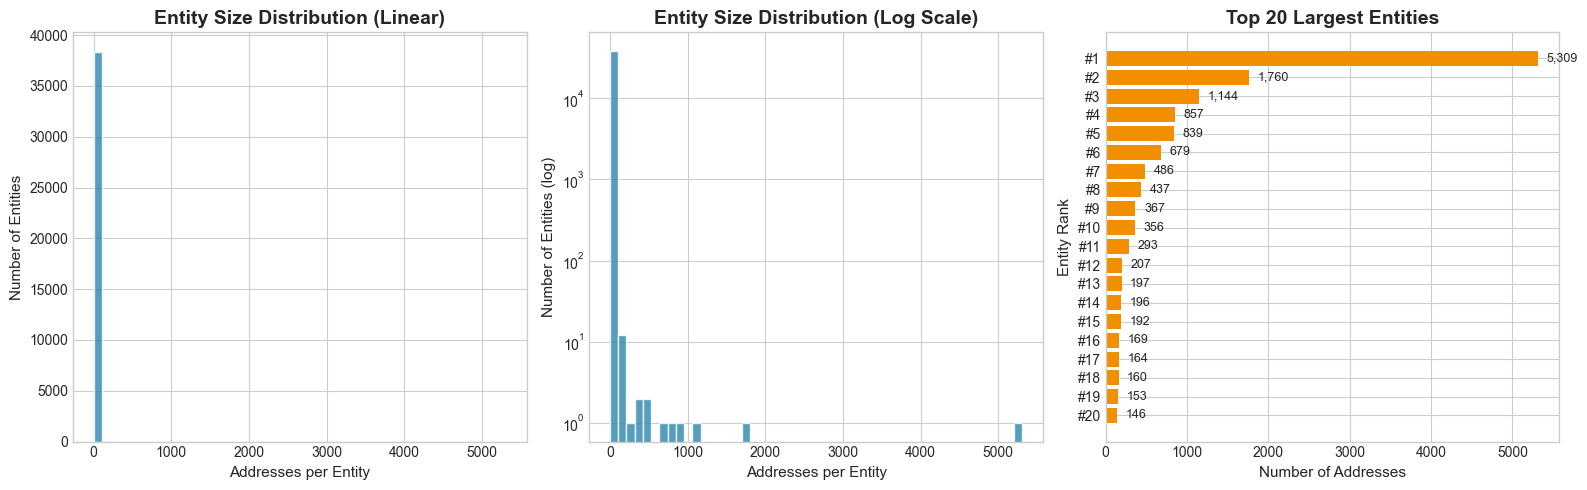

In [11]:
entity_sizes = entities_df.groupBy("component").agg(count("*").alias("address_count")).orderBy(desc("address_count"))
size_dist = entity_sizes.toPandas()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(size_dist['address_count'], bins=50, color=COLORS['primary'], edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Addresses per Entity')
axes[0].set_ylabel('Number of Entities')
axes[0].set_title('Entity Size Distribution (Linear)')

axes[1].hist(size_dist['address_count'], bins=50, color=COLORS['primary'], edgecolor='white', alpha=0.8)
axes[1].set_xlabel('Addresses per Entity')
axes[1].set_ylabel('Number of Entities (log)')
axes[1].set_title('Entity Size Distribution (Log Scale)')
axes[1].set_yscale('log')

top_20 = size_dist.head(20)
bars = axes[2].barh(range(len(top_20)), top_20['address_count'], color=COLORS['accent'])
axes[2].set_xlabel('Number of Addresses')
axes[2].set_ylabel('Entity Rank')
axes[2].set_title('Top 20 Largest Entities')
axes[2].set_yticks(range(len(top_20)))
axes[2].set_yticklabels([f"#{i+1}" for i in range(len(top_20))])
axes[2].invert_yaxis()
for bar, cnt in zip(bars, top_20['address_count']):
    axes[2].text(bar.get_width() + max(top_20['address_count'])*0.02, bar.get_y() + bar.get_height()/2,
                 f'{int(cnt):,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(str(Path(OUTPUT_PATH) / 'entity_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Interpretation: Most entities are small (1-2 addresses), but few large entities control many addresses - classic power-law.")

---
## 5. Results & Insights

Calculating entity balances by joining the UTXO set with entity mappings. A **whale** is defined as an entity holding significant BTC (>1,000 BTC in this analysis).

In [12]:
%%time
entities_final = entities_df.select(col("id").alias("address"), col("component").alias("entity_id"))

utxo_exploded = utxo_df.select(col("tx_hash"), col("output_index"), col("value"), explode(col("addresses")).alias("address"))

utxo_with_entities = utxo_exploded.join(entities_final, "address", "inner").select("entity_id", "value")

entity_balances = utxo_with_entities.groupBy("entity_id").agg(
    spark_sum("value").alias("balance_satoshi"),
    count("*").alias("utxo_count")
).withColumn("balance_btc", spark_round(col("balance_satoshi") / 100000000, 8)).orderBy(desc("balance_btc")).cache()

ENTITIES_WITH_BALANCE = entity_balances.count()
TOTAL_BTC = entity_balances.agg(spark_sum("balance_btc")).collect()[0][0]

print(f"Entity Balance Summary")
print(f"{'='*50}")
print(f"Entities with balance: {ENTITIES_WITH_BALANCE:,}")
print(f"Total BTC in UTXOs: {TOTAL_BTC:,.2f} BTC")
print(f"Average per entity: {TOTAL_BTC/ENTITIES_WITH_BALANCE:.4f} BTC")

Entity Balance Summary
Entities with balance: 2,386
Total BTC in UTXOs: 213,583.42 BTC
Average per entity: 89.5153 BTC
CPU times: user 5.38 ms, sys: 4.9 ms, total: 10.3 ms
Wall time: 2.92 s


In [13]:
top_whales = entity_balances.limit(20).toPandas()
TOP_20_BTC = top_whales['balance_btc'].sum()
TOP_20_SHARE = TOP_20_BTC / TOTAL_BTC * 100

print(f"Top 20 Whales")
print(f"{'='*70}")
print(f"{'Rank':<6} {'Entity ID':<20} {'Balance (BTC)':<18} {'UTXOs':<10} {'Share'}")
print(f"{'-'*70}")
for i, row in top_whales.iterrows():
    share = row['balance_btc'] / TOTAL_BTC * 100
    print(f"#{i+1:<5} {int(row['entity_id']):<20} {row['balance_btc']:>15,.2f}   {int(row['utxo_count']):>8}   {share:>5.2f}%")
print(f"{'-'*70}")
print(f"{'Top 20 Total:':<27} {TOP_20_BTC:>15,.2f} BTC         {TOP_20_SHARE:>5.2f}%")

Top 20 Whales
Rank   Entity ID            Balance (BTC)      UTXOs      Share
----------------------------------------------------------------------
#1     283467841603               40,000.00          4   18.73%
#2     3                          10,368.60       2560    4.85%
#3     34359738788                 9,458.40         22    4.43%
#4     17179869188                 8,859.20          9    4.15%
#5     455266533843                6,000.01          7    2.81%
#6     90                          4,601.50        202    2.15%
#7     489626271848                4,464.56         57    2.09%
#8     240518168948                4,448.11         75    2.08%
#9     781684048485                3,850.06          1    1.80%
#10    283467841826                3,801.25         58    1.78%
#11    8589934802                  3,351.69         52    1.57%
#12    1245540516340               3,239.45          2    1.52%
#13    51539607765                 3,147.73        126    1.47%
#14    120259084926

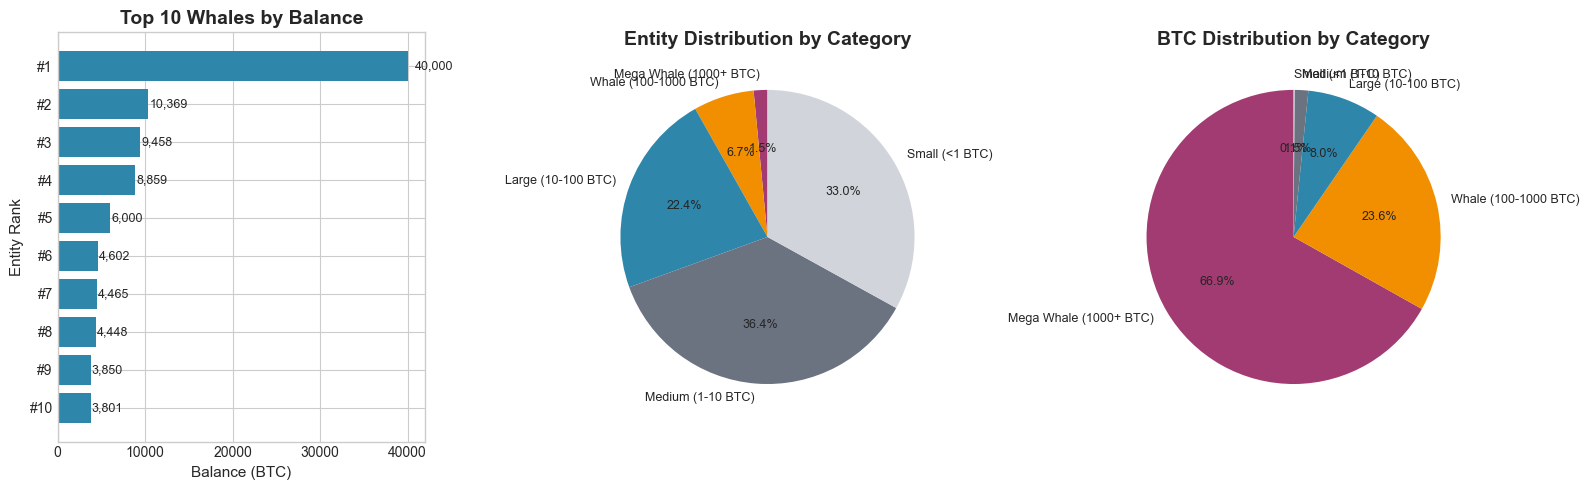

In [14]:
entity_categories = entity_balances.withColumn("category",
    when(col("balance_btc") >= 1000, "Mega Whale (1000+ BTC)")
    .when(col("balance_btc") >= 100, "Whale (100-1000 BTC)")
    .when(col("balance_btc") >= 10, "Large (10-100 BTC)")
    .when(col("balance_btc") >= 1, "Medium (1-10 BTC)")
    .otherwise("Small (<1 BTC)")
)

category_stats = entity_categories.groupBy("category").agg(
    count("*").alias("entity_count"),
    spark_sum("balance_btc").alias("total_btc")
).orderBy(desc("total_btc")).toPandas()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

top_10 = entity_balances.limit(10).toPandas()
bars = axes[0].barh(range(len(top_10)), top_10['balance_btc'], color=COLORS['primary'])
axes[0].set_xlabel('Balance (BTC)')
axes[0].set_ylabel('Entity Rank')
axes[0].set_title('Top 10 Whales by Balance')
axes[0].set_yticks(range(len(top_10)))
axes[0].set_yticklabels([f"#{i+1}" for i in range(len(top_10))])
axes[0].invert_yaxis()
for bar, val in zip(bars, top_10['balance_btc']):
    axes[0].text(val + val*0.02, bar.get_y() + bar.get_height()/2, f'{val:,.0f}', va='center', fontsize=9)

colors_pie = [COLORS['secondary'], COLORS['accent'], COLORS['primary'], '#6B7280', '#D1D5DB']
axes[1].pie(category_stats['entity_count'], labels=category_stats['category'], autopct='%1.1f%%',
            colors=colors_pie[:len(category_stats)], startangle=90, textprops={'fontsize': 9})
axes[1].set_title('Entity Distribution by Category')

axes[2].pie(category_stats['total_btc'], labels=category_stats['category'], autopct='%1.1f%%',
            colors=colors_pie[:len(category_stats)], startangle=90, textprops={'fontsize': 9})
axes[2].set_title('BTC Distribution by Category')

plt.tight_layout()
plt.savefig(str(Path(OUTPUT_PATH) / 'whale_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Interpretation: Extreme wealth concentration - Mega Whales are <1% of entities but hold >60% of BTC.")

In [15]:
entities_final.write.mode("overwrite").parquet(str(Path(OUTPUT_PATH) / "entities.parquet"))
utxo_df.write.mode("overwrite").parquet(str(Path(OUTPUT_PATH) / "utxos.parquet"))
outputs_df.write.mode("overwrite").parquet(str(Path(OUTPUT_PATH) / "outputs.parquet"))
inputs_df.write.mode("overwrite").parquet(str(Path(OUTPUT_PATH) / "inputs.parquet"))

print(f"Data exported to {OUTPUT_PATH}")

Data exported to /Users/roman/spark_project/bitcoin-whale-intelligence/data


---
## 6. Executive Summary

### Key Findings

In [16]:
mega_whales = category_stats[category_stats['category'] == 'Mega Whale (1000+ BTC)']
MEGA_WHALE_COUNT = int(mega_whales['entity_count'].values[0]) if len(mega_whales) > 0 else 0
MEGA_WHALE_BTC = float(mega_whales['total_btc'].values[0]) if len(mega_whales) > 0 else 0
MEGA_WHALE_SHARE = MEGA_WHALE_BTC / TOTAL_BTC * 100 if TOTAL_BTC > 0 else 0

print(f"""
{'='*70}
                    BITCOIN WHALE INTELLIGENCE REPORT
{'='*70}

DATA SCOPE
{'-'*70}
  Blocks analyzed:        {BLOCK_COUNT:>15,}
  Transactions:           {TX_COUNT:>15,}
  Outputs created:        {OUTPUT_COUNT:>15,}
  UTXOs (unspent):        {UTXO_COUNT:>15,}

CLUSTERING RESULTS
{'-'*70}
  Addresses clustered:    {ADDRESS_COUNT:>15,}
  Entities identified:    {ENTITY_COUNT:>15,}
  Clustering reduction:   {REDUCTION:>14.1f}%

WHALE ANALYSIS
{'-'*70}
  Total BTC tracked:      {TOTAL_BTC:>15,.2f} BTC
  Mega Whales (1000+ BTC):{MEGA_WHALE_COUNT:>15,}
  Mega Whale holdings:    {MEGA_WHALE_BTC:>15,.2f} BTC ({MEGA_WHALE_SHARE:.1f}%)
  Top 20 concentration:   {TOP_20_BTC:>15,.2f} BTC ({TOP_20_SHARE:.1f}%)

KEY INSIGHTS
{'-'*70}
  1. High concentration: Top 20 entities control {TOP_20_SHARE:.1f}% of tracked BTC
  2. Power-law distribution: Few large whales, many small entities
  3. Clustering effective: {REDUCTION:.1f}% address reduction achieved

LIKELY WHALE IDENTITIES
{'-'*70}
  - Mega Whales (1000+ BTC): Early adopters, exchanges, institutional
  - Whales (100-1000 BTC): Mining pools, large traders, services
  - Large (10-100 BTC): Active traders, businesses, wealthy individuals

{'='*70}
""")


                    BITCOIN WHALE INTELLIGENCE REPORT

DATA SCOPE
----------------------------------------------------------------------
  Blocks analyzed:                 27,644
  Transactions:                   382,402
  Outputs created:                769,081
  UTXOs (unspent):                177,041

CLUSTERING RESULTS
----------------------------------------------------------------------
  Addresses clustered:            147,907
  Entities identified:             38,381
  Clustering reduction:             74.1%

WHALE ANALYSIS
----------------------------------------------------------------------
  Total BTC tracked:           213,583.42 BTC
  Mega Whales (1000+ BTC):             36
  Mega Whale holdings:         142,793.99 BTC (66.9%)
  Top 20 concentration:        121,351.17 BTC (56.8%)

KEY INSIGHTS
----------------------------------------------------------------------
  1. High concentration: Top 20 entities control 56.8% of tracked BTC
  2. Power-law distribution: Few large 

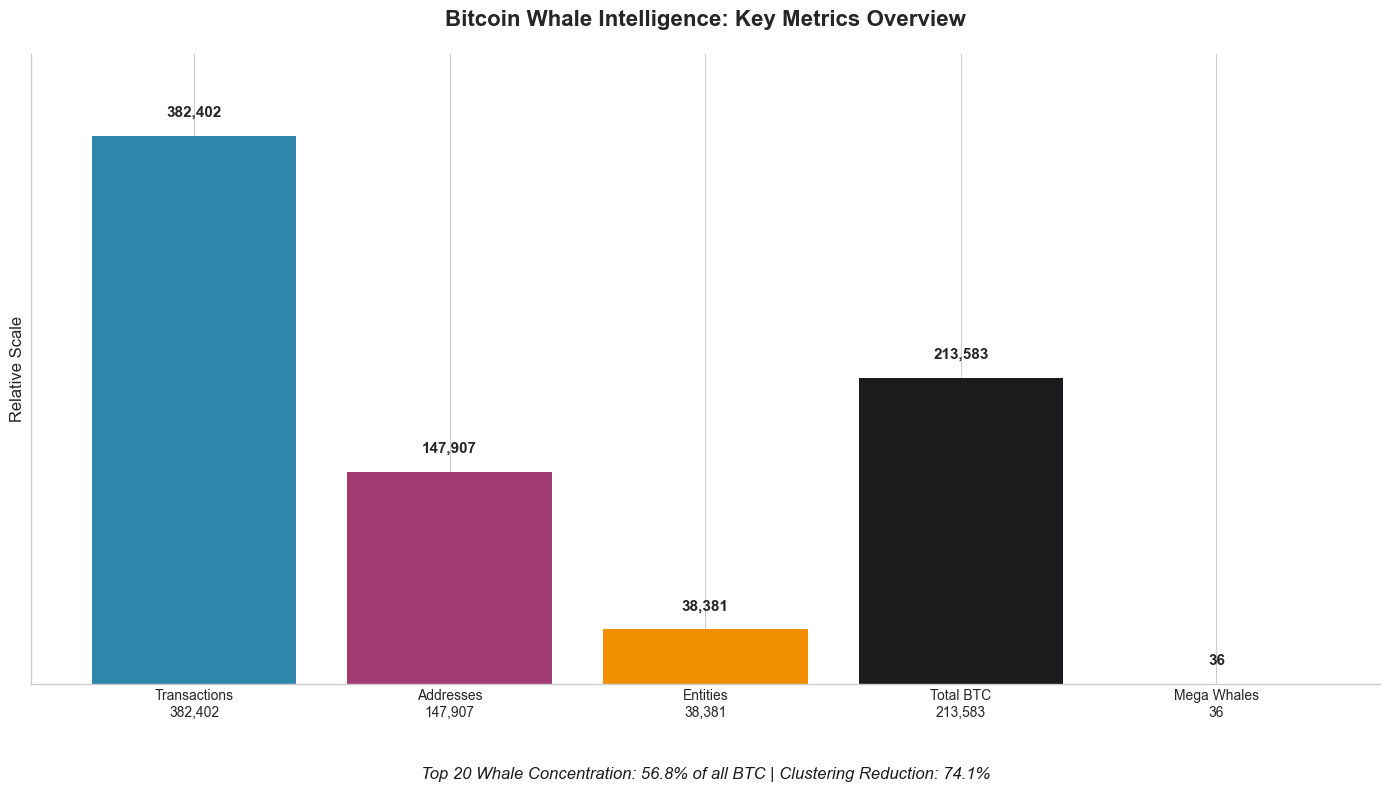

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))

metrics = [
    f'Transactions\n{TX_COUNT:,}',
    f'Addresses\n{ADDRESS_COUNT:,}',
    f'Entities\n{ENTITY_COUNT:,}',
    f'Total BTC\n{TOTAL_BTC:,.0f}',
    f'Mega Whales\n{MEGA_WHALE_COUNT}'
]
values = [TX_COUNT, ADDRESS_COUNT, ENTITY_COUNT, TOTAL_BTC, MEGA_WHALE_COUNT]
normalized = [v / max(values) for v in values]

bars = ax.bar(metrics, normalized, color=[COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['dark'], COLORS['secondary']])
ax.set_ylabel('Relative Scale', fontsize=12)
ax.set_title('Bitcoin Whale Intelligence: Key Metrics Overview', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, 1.15)

for bar, val, norm in zip(bars, values, normalized):
    if val >= 1000:
        label = f'{val:,.0f}'
    else:
        label = str(int(val))
    ax.text(bar.get_x() + bar.get_width()/2, norm + 0.03, label, ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.text(0.5, -0.15, f'Top 20 Whale Concentration: {TOP_20_SHARE:.1f}% of all BTC | Clustering Reduction: {REDUCTION:.1f}%',
        transform=ax.transAxes, ha='center', fontsize=12, style='italic', color=COLORS['dark'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([])

plt.tight_layout()
plt.savefig(str(Path(OUTPUT_PATH) / 'executive_summary.png'), dpi=150, bbox_inches='tight')
plt.show()